In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pycocotools.coco import COCO
from collections import defaultdict, Counter

col_ref = np.genfromtxt('/opt/ml/input/code/class_dict.csv', skip_header=1, usecols=(1,2,3), delimiter=',', dtype=int)
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

COLORS_HEX = []
for x in col_ref:
    COLORS_HEX.append(rgb_to_hex(tuple(x)))

In [9]:
dataset_path  = '/opt/ml/input/data'
anns_all_file_path = dataset_path + '/' + 'train_all.json'
anns_tr_file_path = dataset_path + '/' + 'train.json'
anns_val_file_path = dataset_path + '/' + 'val.json'

In [10]:
class get_info():
    def __init__(self, cocopath):
        # load coco data
        self.coco = COCO(cocopath)

        self.anno_cls = []       # anno. cls (N_anno)
        self.anno_area = []      # anno. area fraction? (N_anno)
        self.N_anno = [] # (N_anno) #cls_anno = defaultdict(list) # img. cls별로 몇개의 anno가 들어있는 img인지 (10개 list. img당 anno 개수)
        self.img_N_anno = []     # img별 anno. 개수 (N_img)
        
        self.image_id = self.coco.getImgIds()
        self.image_infos = self.coco.loadImgs(self.image_id)

        self.image_h = self.image_infos[0]['height']
        self.image_w = self.image_infos[0]['width']
        self.image_a = self.image_h * self.image_w
        self.cat_ids = self.coco.getCatIds()           # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        self.cats = self.coco.loadCats(self.cat_ids)        # [{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'}, ~]

        for image_info in self.image_infos:
            ann_ids = self.coco.getAnnIds(imgIds=image_info['id']) # {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0002.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}
            anns = self.coco.loadAnns(ann_ids)
            self.img_N_anno.append(len(anns))

            for ann in anns:
                self.anno_cls.append(ann['category_id'])
                self.anno_area.append(ann['area'])
                self.N_anno.append(len(anns)) #cls_anno[ann['category_id']].append(len(anns))

        self.anno_cls = np.array(self.anno_cls)
        self.anno_area = np.array(self.anno_area)
        self.N_anno = np.array(self.N_anno)
        self.img_N_anno = np.array(self.img_N_anno)
        
dat_all = get_info(anns_all_file_path)
dat_tr = get_info(anns_tr_file_path)
dat_val = get_info(anns_val_file_path)

num_to_name = ['bg' for i in range(11)]
for i in dat_all.cats:
    num_to_name[i['id']] = i['name']


loading annotations into memory...
Done (t=2.12s)
creating index...
index created!
loading annotations into memory...
Done (t=1.87s)
creating index...
index created!
loading annotations into memory...
Done (t=2.34s)
creating index...
index created!


In [7]:
print(len(dat_tr.img_N_anno)//8)
print(len(dat_tr.img_N_anno)%16)
print(len(dat_val.img_N_anno)%8)

NameError: name 'dat_tr' is not defined

                all    tr   val   colors
Paper          4983  4798  5115  #0080c0
Plastic bag    4107  4125  3996  #c0c080
Plastic        1707  1647  1590  #4000c0
General trash  1488  1488  1474  #c00080
Styrofoam       750   726   672  #c08040
Paper pack      363   338   353  #008040
Glass           293   378   305  #400080
Metal           280   282   336  #800000
Clothing         84    96   102  #8000c0
Battery          19    34    47  #404080


(0.0, 1.0)

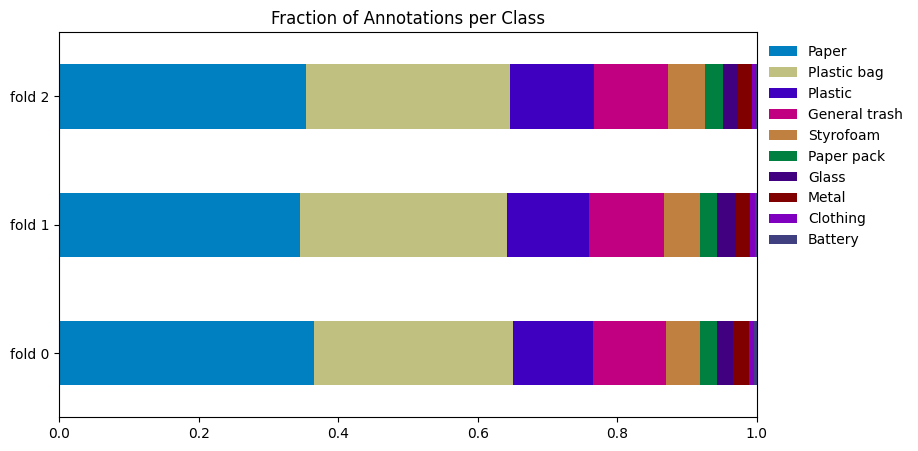

In [12]:
# bar plots cls
df_cls = pd.DataFrame([Counter(dat_all.anno_cls), (Counter(dat_tr.anno_cls)), (Counter(dat_val.anno_cls))]).T
df_cls.columns=['all', 'tr', 'val']

num_to_name = ['bg' for i in range(11)]
for i in dat_all.cats:
    num_to_name[i['id']] = i['name']

idx = []
cols = []
for i in df_cls.index:
    idx.append(num_to_name[i])
    cols.append(COLORS_HEX[i])

df_cls.index = idx
df_cls['colors'] = cols
print(df_cls.sort_values(by='all', ascending=False))

df_cls['all'] = df_cls['all']/sum(df_cls['all'])
df_cls['val'] = df_cls['val']/sum(df_cls['val'])
df_cls['tr'] = df_cls['tr']/sum(df_cls['tr'])
df_cls = df_cls.sort_values(by='all', ascending=False).T

df_cls_plot = df_cls.reindex(['val', 'tr', 'all'])

f, ax = plt.subplots(figsize=(9, 5))
df_cls_plot.plot(kind='barh', ax=ax, stacked=True, color=df_cls.loc['colors'])
ax.set_title('Fraction of Annotations per Class')
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
ax.set_yticklabels(['fold 0', 'fold 1', 'fold 2'])
ax.set_xlim(0, 1)

Text(0, 0.5, '# image')

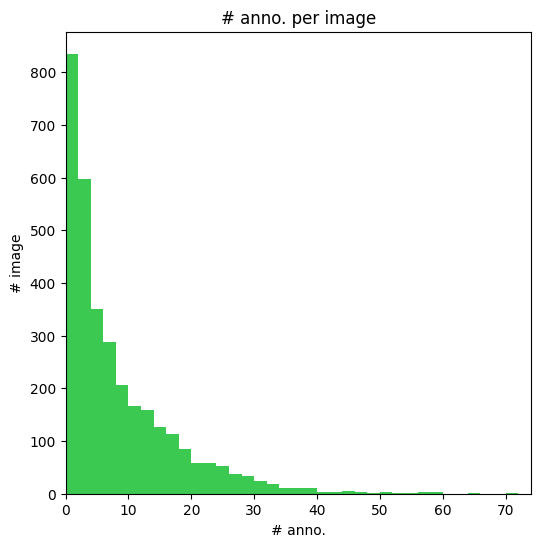

In [170]:
# anno. per image histogram
f, ax = plt.subplots(figsize=(6, 6))
_, b, p = ax.hist(dat_all.img_N_anno, bins=36, range=(0, 72), color='#3cc952')
ax.set_xlim(0, 74)
ax.set_title('# anno. per image')
ax.set_xlabel('# anno.')
ax.set_ylabel('# image')

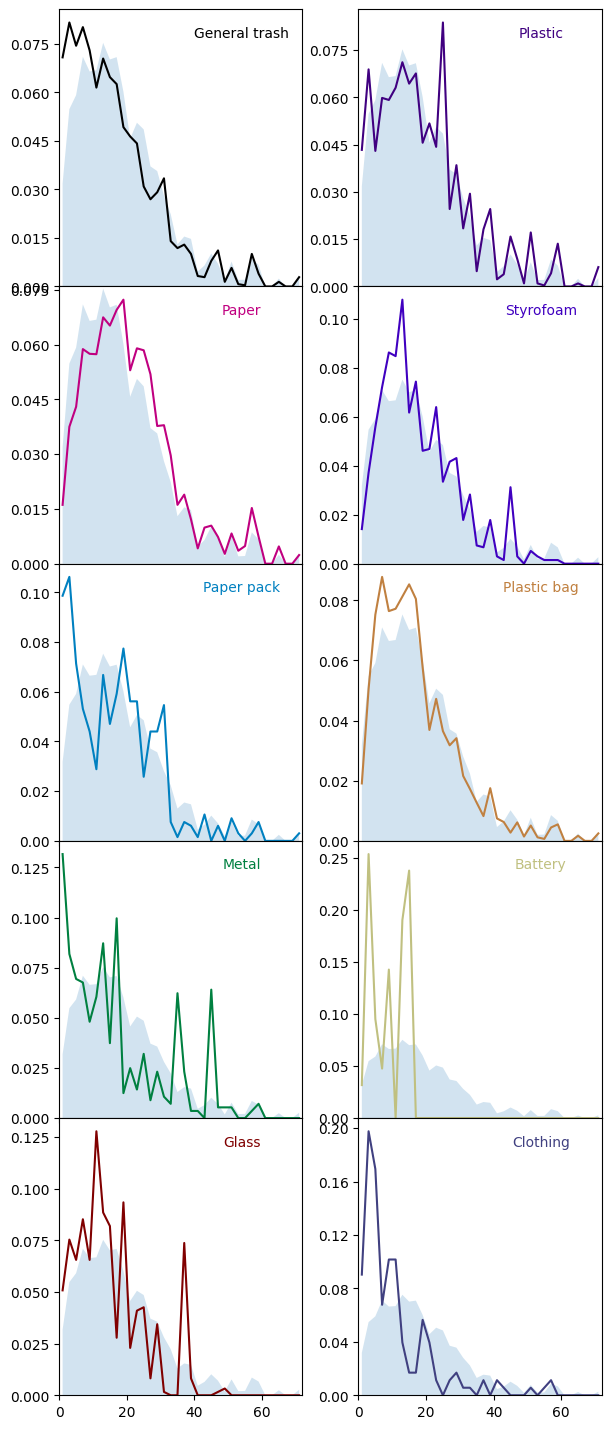

In [291]:
# Num_anno. histogram per cls
from matplotlib.ticker import MaxNLocator

f, axes = plt.subplots(5, 2, figsize=(7, 18))
f.subplots_adjust(wspace=0.23, hspace=0)
for i in range(5):
    if i!=4:
        axes[i][0].set_xticklabels([])
        axes[i][1].set_xticklabels([])
    axes[i][0].yaxis.set_major_locator(MaxNLocator(6))
    axes[i][1].yaxis.set_major_locator(MaxNLocator(6))

his_main, edges = np.histogram(dat_all.N_anno, bins=36, range=(0, 72))
his_main = his_main/sum(his_main)

for i in range(1, 11):
    his, edges = np.histogram(dat_all.N_anno[dat_all.anno_cls==i], bins=36, range=(0, 72))
    tot_sample = sum(his)
    centers = (edges[1:] + edges[:-1])/2
    
    ax = axes[(i-1)%5][(i-1)//5]
    ax.fill_between(centers, his_main, 0, alpha=0.2)

    ax.plot(centers, his/tot_sample, linewidth=1.5, color=COLORS_HEX[i-1])
    ax.text(0.75, 0.9, num_to_name[i], transform=ax.transAxes, horizontalalignment='center',color=COLORS_HEX[i-1])
    ax.set_xlim(0, 72)
    ax.set_ylim(0, max(his)/tot_sample*1.05)
    

['bg', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


[Text(0, -10, 'Clothing'),
 Text(0, -9, 'Battery'),
 Text(0, -8, 'Plastic bag'),
 Text(0, -7, 'Styrofoam'),
 Text(0, -6, 'Plastic'),
 Text(0, -5, 'Glass'),
 Text(0, -4, 'Metal'),
 Text(0, -3, 'Paper pack'),
 Text(0, -2, 'Paper'),
 Text(0, -1, 'General trash'),
 Text(0, 0, 'total')]

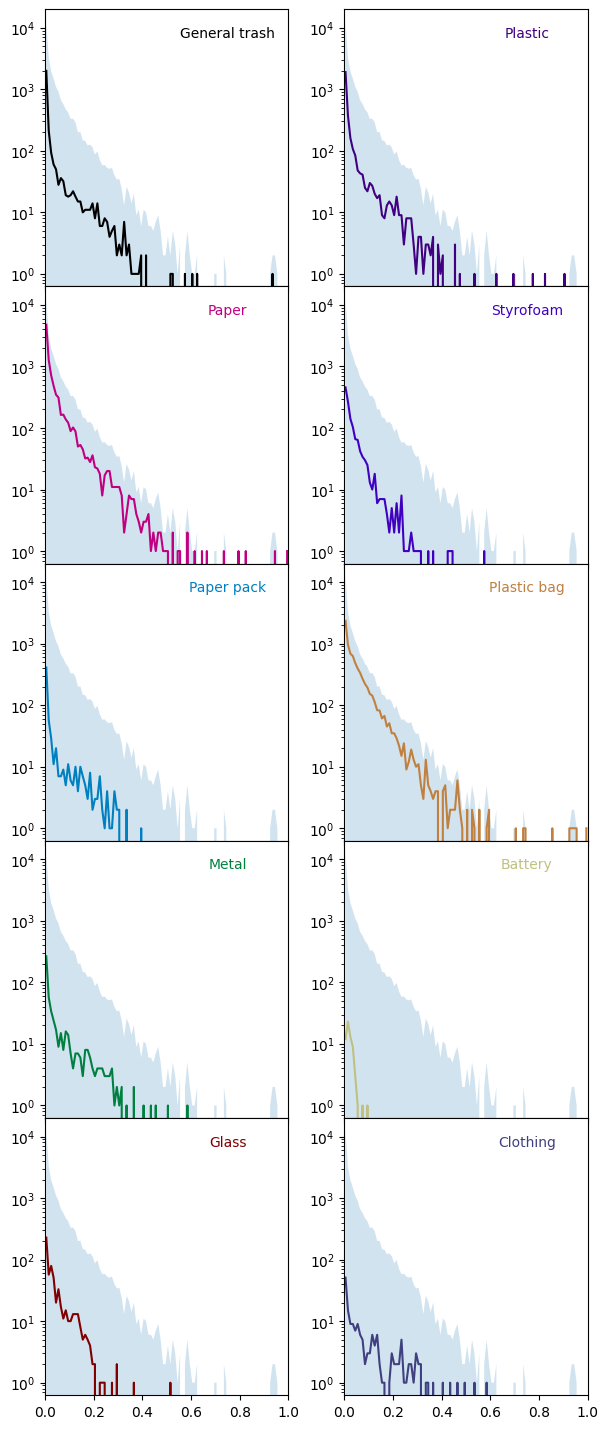

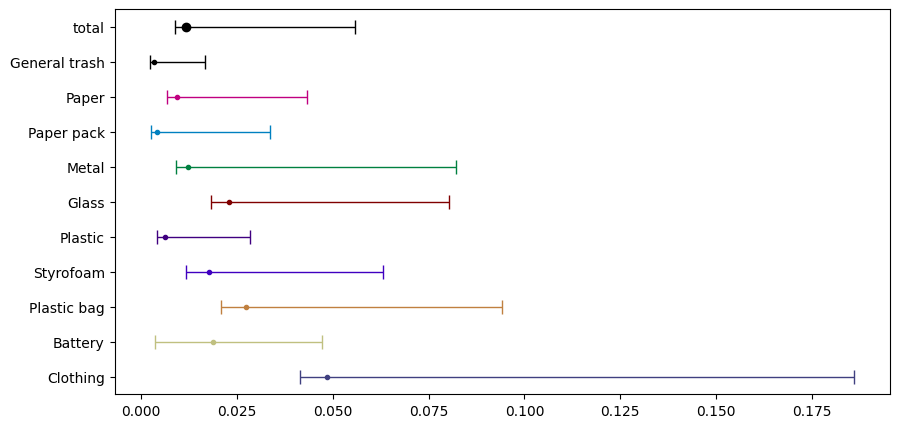

In [292]:
# anno area. histogram per cls
from matplotlib.ticker import MaxNLocator

f, axes = plt.subplots(5, 2, figsize=(7, 18))
f.subplots_adjust(wspace=0.23, hspace=0)
for i in range(5):
    if i!=4:
        axes[i][0].set_xticklabels([])
        axes[i][1].set_xticklabels([])
    axes[i][0].yaxis.set_major_locator(MaxNLocator(6))
    axes[i][1].yaxis.set_major_locator(MaxNLocator(6))

his_main, edges = np.histogram(dat_all.anno_area/dat_all.image_a, bins=100, range=(0, 1))

for i in range(1, 11):
    his, edges = np.histogram(dat_all.anno_area[dat_all.anno_cls==i]/dat_all.image_a, bins=100, range=(0, 1))
    centers = (edges[1:] + edges[:-1])/2
    
    ax = axes[(i-1)%5][(i-1)//5]
    ax.fill_between(centers, his_main, 0, alpha=0.2)
    ax.plot(centers, his, linewidth=1.5, color=COLORS_HEX[i-1])
    ax.text(0.75, 0.9, num_to_name[i], transform=ax.transAxes, horizontalalignment='center',color=COLORS_HEX[i-1])
    ax.set_yscale('log')
    ax.set_xlim(0, 1)


print(num_to_name)
f, ax = plt.subplots(figsize=(10, 5))
his_main_stat = np.percentile(dat_all.anno_area/dat_all.image_a, [25, 50, 75])
ax.errorbar(his_main_stat[1], 0, xerr=([his_main_stat[0]], [his_main_stat[2]]), fmt='o', c='k', ecolor='k', elinewidth=1, capsize=5)
for i in range(1, 11):
    stat = np.percentile(dat_all.anno_area[dat_all.anno_cls==i]/dat_all.image_a, [25, 50, 75])
    ax.errorbar(stat[1], -i, xerr=([stat[0]], [stat[2]]), fmt='.', c=COLORS_HEX[i-1], ecolor=COLORS_HEX[i-1], elinewidth=1, capsize=5)
ax.set_yticks(np.arange(-10, 1))
ax.set_yticklabels(num_to_name[1:][::-1] + ['total'])

In [22]:
"""
for ann in anns:
    print(ann['area'])
    print(len(ann['segmentation']))
    print(ann['segmentation'][0][:10])
    print(ann['segmentation'][1][:10])
    print(ann['segmentation'][2][:10])
    coco.annToMask(ann['segmentation'])
    #masks[self.coco.annToMask(anns[i]) == 1] = pixel_value

    assert False
"""

loading annotations into memory...
Done (t=6.57s)
creating index...
index created!
